<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2023</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block>
        <font size=3>Homework 2 - Part 2</font><br>
        <hr />
        <font size=3>TA: <a href="mailto:p.zilouchian@ut.ac.ir">Parham Zilouchian</a><br></font><br>
        <font size=3>TA: <a href="mailto:alirezaghafouri@ut.ac.ir">Alireza Ghafouri</a><br></font><br>
        
    </div>
</div>

# Working with GANs using PyTorch

This notebook is a homework assignment for the Deep Generative Models course at the University of Tehran. The goal of this assignment is to get familiar with the concept of Generative Adversarial Networks (GANs) and how to implement it with PyTorch. We will use the MNIST dataset for this assignment.

---


**Requisites**

*   Python 3.x
*   Jupyter
*   PyTorch >= 1.8
*   NumPy
*   Matplotlib
---

In [1]:
!free -m
!df -h
!nvidia-smi

'free' is not recognized as an internal or external command,
operable program or batch file.
'df' is not recognized as an internal or external command,
operable program or batch file.


Wed Dec  6 18:55:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P0              19W /  95W |    396MiB /  6144MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Import Libraries:**

Import your required libraries!

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision

import argparse
import numpy as np
import os
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.utils as vutils

from torch import autograd, nn, optim
from torch.nn import functional as F

import argparse
from pprint import pprint
from torchvision import datasets, transforms

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(666) # set by me

import random # added by me

random.seed(666) # added by me
np.random.seed(666) # added by me

## **Downloading the dataset:**

We will use the MNIST dataset for this assignment. The dataset is already available in PyTorch, so we just need to download it.

In [4]:
preprocess = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root='./data', train=True, download=True, transform=preprocess),
            batch_size=128,
            shuffle=True
        )
test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root='./data', train=False, download=True, transform=preprocess),
            batch_size=128,
            shuffle=True
        )

# Create pre-processed training and test sets
X_train = train_loader.dataset.data.to(device).reshape(-1, 784).float() / 255
y_train = train_loader.dataset.data.to(device)
X_test = test_loader.dataset.data.to(device).reshape(-1, 784).float() / 255
y_test = test_loader.dataset.data.to(device)

print('Train dataset shape: ', X_train.data.shape)
print('Test dataset shape: ', y_train.data.shape)

Train dataset shape:  torch.Size([60000, 784])
Test dataset shape:  torch.Size([60000, 28, 28])


In [5]:
class Reshape(torch.nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.reshape(x.size(0), *self.shape)


class ReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.maximum(x, torch.zeros_like(x))

## **Define Generator:**

We will use a simple 5-layer convolutional neural network for this assignment. The network is defined in the `Net` class below. The network is composed of 3 convolutional layers and 2 fully connected layers.

In [6]:
class Generator(torch.nn.Module):
    def __init__(self, z_dim=64, num_channels=1):
        super().__init__()
        self.z_dim = z_dim

        ############################# TODO #############################
        # Complete this part according to the introduced generator table on the provided manuscript!

        # YOUR CODE STARTS HERE

        self.fc = nn.Sequential(
            nn.Linear(in_features=z_dim, out_features=512),
            nn.BatchNorm1d(512),
            ReLU(),

            nn.Linear(in_features=512, out_features=3136), # 64 * 7 * 7 = 3136
            nn.BatchNorm1d(3136), # 64 * 7 * 7 = 3136
            ReLU()
        )

        self.reshape = Reshape(64, 7, 7)

        self.conv = nn.Sequential(
            nn.PixelShuffle(2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            ReLU(),

            nn.PixelShuffle(2),

            nn.Conv2d(in_channels=8, out_channels=num_channels, kernel_size=3, padding=1),
        )

        # YOUR CODE ENDS HERE

    def forward(self, z):
        z = self.fc(z)

        z = self.reshape(z)

        z = self.conv(z)

        return z

## **Define Discriminator:**

We will use a simple 5-layer convolutional neural network for this assignment. The network is defined in the `Net` class below. The network is composed of 3 convolutional layers and 2 fully connected layers.

In [7]:
class Discriminator(torch.nn.Module):
    def __init__(self, num_channels=1):
        super().__init__()

        ############################# TODO #############################
        # Complete this part according to the introduced discriminator table on the provided manuscript!

        # YOUR CODE STARTS HERE

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=4, stride=2, padding=1),
            ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            ReLU()
        )

        self.reshape1 = Reshape(64 * 7 * 7)

        self.fc = nn.Sequential(
            nn.Linear(in_features=3136, out_features=512), # 64 * 7 * 7 = 3136
            ReLU(),

            nn.Linear(in_features=512, out_features=1),
        )

        self.reshape2 = Reshape()

        # YOUR CODE ENDS HERE

    def forward(self, x):
        x = self.conv(x)

        x = self.reshape1(x)

        x = self.fc(x)

        x = self.reshape2(x)

        return x

## **Define Your GAN:**

In [8]:
class GAN(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.z_dim = z_dim
        self.g = Generator(z_dim=z_dim)
        self.d = Discriminator()   # note that discriminator outputs logits

    def loss_nonsaturating(self, x_real, *, device):
        '''
        Input Arguments:

        - x_real (torch.Tensor): training data samples (64, 1, 28, 28)
        - device (torch.device): 'cpu' by default

        Returns:
        - d_loss (torch.Tensor): nonsaturating discriminator loss
        - g_loss (torch.Tensor): nonsaturating generator loss
        '''

        ############################# TODO #############################
        # YOUR CODE STARTS HERE

        batch_size = x_real.shape[0]
        
        z = torch.randn(batch_size, self.g.z_dim, device=device)

        x_fake = self.g(z)
        
        d_real = self.d(x_real)
        d_fake = self.d(x_fake)

        d_loss = -F.logsigmoid(d_real).mean() - F.logsigmoid(-d_fake).mean()
        g_loss = -F.logsigmoid(d_fake).mean()

        # YOUR CODE ENDS HERE


        return d_loss, g_loss

    def loss_wasserstein(self, x_real, *, device):
        batch_size = x_real.shape[0]

        z = torch.randn(batch_size, self.g.z_dim, device=device)
        alpha = torch.rand(batch_size, 1, 1, 1, device=device)

        x_fake = self.g(z)

        x = alpha * x_fake + (1 - alpha) * x_real
        x_grads = torch.autograd.grad(self.d(x).sum(), x, create_graph=True)
        norms = (x_grads[0] ** 2).sum(dim=(1, 2, 3)).sqrt()

        d_real = self.d(x_real)
        d_fake = self.d(x_fake)
        
        d_loss = d_fake - d_real
        d_loss = d_loss + 10 * (norms - 1) ** 2
        d_loss = d_loss.mean()

        g_loss = -d_fake.mean()

        return d_loss, g_loss

## **Training Process:**

In [9]:

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

class Trainer:
    def __init__(self,
                 model,
                 optimizers,
                 device="cuda",
                 iter_max=10000,
                 iter_save=1000,
                 num_latents=100,
                 out_dir="",
                 loss_type="nonsaturating" # i added "loss_type" parameter to select which loss function to use.
            ):
        self.model = model
        self.optimizers = optimizers
        self.device = device
        self.iter_save = iter_save
        self.iter_max = iter_max
        self.out_dir = out_dir
        self.num_latents = num_latents

        # i added "loss_type" parameter to select which loss function to use.
        self.loss_type = loss_type


        # fix visualization latents
        self.z_test = torch.randn(100, self.num_latents).to(device)


    def build_input(self, x, y):
        x_real = x.to(self.device)
        y_real = y.to(self.device)
        return x_real, y_real

    def viz(self, global_step=1):
        with torch.no_grad():
            generator = self.model.g
            generator.eval()
            ############
            fake = ((generator(self.z_test) + 1) / 2.) #.detach().cpu()
            ###############
            generator.train()
        torchvision.utils.save_image(fake, '%s/fake_%04d.png' % (self.out_dir, global_step), nrow=10, padding=2, normalize=True)
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True, nrow=10))


    def checkpoint_and_log(self, global_step, loss, summaries):
        if global_step % self.iter_save == 0:
            with torch.no_grad():
                self.viz(global_step)
                torch.save((self.model.g, self.model.d), '%s/model_%04d.pt' % (self.out_dir, global_step))


    def gan_step(self, x_real, y_real): 
        assert len(self.optimizers) == 2


        ############################# TODO #############################
        # Here you should calculate the loss for both the generator and discriminator parts!
        # After that, you have to apply this calculated loss to both the networks and update their weights respectively.
        # Here you have to use the "checkpoint_and_log" function in order to visualize and make checkpoint from your model!

        # YOUR CODE STARTS HERE

        # these lines are added by me.
        if self.loss_type == "nonsaturating":
            d_loss, g_loss = self.model.loss_nonsaturating(x_real, device=self.device)
        elif self.loss_type == "wasserstein":
            d_loss, g_loss = self.model.loss_wasserstein(x_real, device=self.device)

        self.optimizers[1].zero_grad()
        d_loss.backward(retain_graph=True)
        self.optimizers[1].step()

        self.optimizers[0].zero_grad()
        g_loss.backward()
        self.optimizers[0].step()

        # i used "checkpoint_and_log" function in "train" function, where "global_step" variable was initialized, since, \
        # in this function (meaning "gan_step") does not have any "global_step" variable.

        # YOUR CODE ENDS HERE

        return d_loss, g_loss



    def train(self, train_loader, reinit=False):
        global_step = 0

        # train model from scratch
        if reinit:
            ############################# TODO #############################
            # OPTIONAL: Here you can Initialize your model if you want!

            # YOUR CODE STARTS HERE

            
            
            # YOUR CODE ENDS HERE
            pass

        # train models for multiple epochs
        with tqdm(total=int(self.iter_max)) as pbar:
            ############################# TODO #############################
            # Here is your training loop!
            # YOUR CODE STARTS HERE

            for epoch in range(int(self.iter_max)):
                d_loss_tmp = 0
                g_loss_tmp = 0

                iter = 0
                
                for x_real, y_real in train_loader:
                    x_real, y_real = self.build_input(x_real, y_real)

                    d_loss, g_loss = self.gan_step(x_real, y_real)

                    d_loss_tmp += d_loss.item()
                    g_loss_tmp += g_loss.item()

                    self.checkpoint_and_log(global_step, (d_loss, g_loss), [])

                    global_step += 1
                    
                    pbar.update(1)

                    iter += 1
                    
                    if global_step >= self.iter_max:
                        break

                d_loss_tmp = d_loss_tmp / iter
                g_loss_tmp = g_loss_tmp / iter

                D_losses.append(d_loss_tmp)
                G_losses.append(g_loss_tmp)

            # YOUR CODE ENDS HERE
            pass

In [10]:
def build_model(device='cpu', num_latents=64):
    model = GAN(z_dim=num_latents)
    return model.to(device)


def build_optimizers(model):
    g_opt = torch.optim.Adam(model.g.parameters(), lr=1e-3)
    d_opt = torch.optim.Adam(model.d.parameters(), lr=1e-3)
    optimizers = [g_opt, d_opt]
    return optimizers

num_latents = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_model(device, num_latents=num_latents)
optimizers = build_optimizers(model)


trainer = Trainer(model, optimizers,
                    device=device,
                    iter_max=10000,
                    num_latents=num_latents,
                    out_dir='./'
                  )

trainer.train(train_loader)

trainer.viz()

19978it [09:02, 36.83it/s]                                                                                           


## **Plot Losses:**

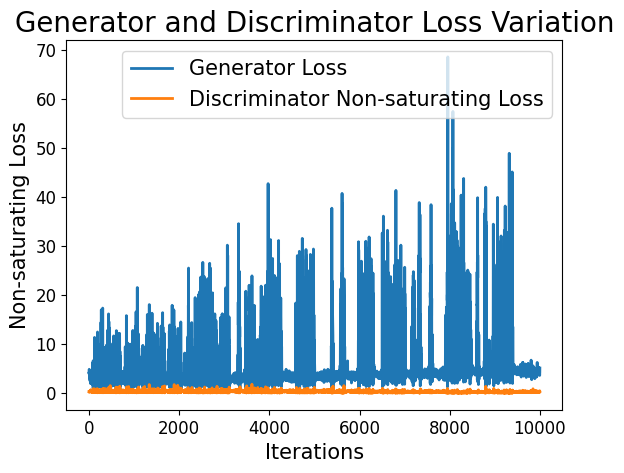

In [11]:
############################# TODO #############################
# Here, you should use the "G_losses", and "D_losses" in order to plot the "Loss Values Variation Diagram".

# YOUR CODE STARTS HERE

plt.plot(G_losses, label="Generator Loss", linewidth=2)
plt.plot(D_losses, label="Discriminator Non-saturating Loss", linewidth=2)

plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Non-saturating Loss", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("Generator and Discriminator Loss Variation", fontsize=20)

plt.legend(loc="best", fontsize=15)

plt.show()

# YOUR CODE ENDS HERE

## **Visualization:**

By using the "img_list" you can visualize the animation of changes that occurred during training.

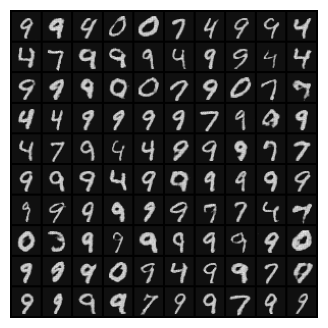

In [12]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(4, 4))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.detach().cpu(), (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Calculate FID-score:

In [13]:
from torchvision.utils import save_image

torch.manual_seed(666) # added by me
random.seed(666) # added by me
np.random.seed(666) # added by me

model.eval()

# generate 3000 samples 
for k in range(3000):
    with torch.no_grad():
        z_test = torch.randn(1, 64).to(device)
        
        fake = (model.g(z_test) + 1) / 2.
        
    save_image(fake, f"gan_generated_images/sample_{k}.png", padding=2, normalize=True)

In [14]:
# TODO: compute the FID score using pytorch-fid package.
# You should have two image directories to compute the score: 
# 1- Directory of the original images.
# 2- Directory of the generated images (the directory that you created in the last code cell)

from pytorch_fid import fid_score

torch.manual_seed(666) # added by me
random.seed(666) # added by me
np.random.seed(666) # added by me

random_idxs = random.sample(range(y_test.shape[0]), 3000)

for idx in random_idxs:
    image = y_test[idx].unsqueeze(0) / 255
    save_image(image, f"gan_real_images/sample_{idx}.png", padding=2, normalize=True)

path_to_original_images = "gan_real_images/"
path_to_generated_images = "gan_generated_images/"

fid_value = fid_score.calculate_fid_given_paths([path_to_original_images, path_to_generated_images], batch_size=64, dims=2048, device=device)

print(f"FID Score: {fid_value}")

100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.08it/s]


FID Score: 28.93292668381457


# Wasserstein Loss Experiments:

In [15]:
def build_model(device='cpu', num_latents=64):
    model = GAN(z_dim=num_latents)
    return model.to(device)


def build_optimizers(model):
    g_opt = torch.optim.Adam(model.g.parameters(), lr=1e-3)
    d_opt = torch.optim.Adam(model.d.parameters(), lr=1e-3)
    optimizers = [g_opt, d_opt]
    return optimizers


num_latents = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_model(device, num_latents=num_latents)
optimizers = build_optimizers(model)


trainer = Trainer(model, optimizers,
                    device=device,
                    iter_max=10000,
                    num_latents=num_latents,
                    out_dir='./',
                    loss_type="wasserstein" # added by me
                  )

trainer.train(train_loader)

trainer.viz()

19978it [07:02, 47.33it/s]                                                                                           


# Plot Losses for Wasserstein Loss:

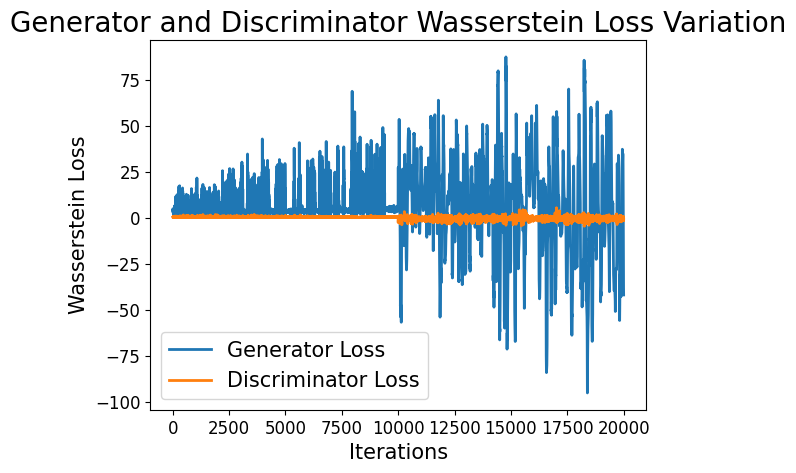

In [16]:
############################# TODO #############################
# Here, you should use the "G_losses", and "D_losses" in order to plot the "Loss Values Variation Diagram".

# YOUR CODE STARTS HERE

plt.plot(G_losses, label="Generator Loss", linewidth=2)
plt.plot(D_losses, label="Discriminator Loss", linewidth=2)

plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Wasserstein Loss", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("Generator and Discriminator Wasserstein Loss Variation", fontsize=20)

plt.legend(loc="best", fontsize=15)

plt.show()

# YOUR CODE ENDS HERE

## **Visualization for Wasserstein Loss:**

By using the "img_list" you can visualize the animation of changes that occurred during training.

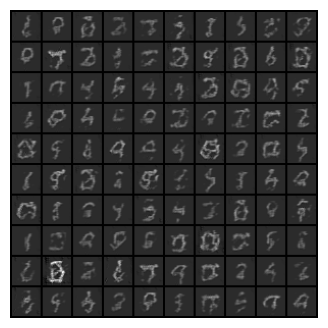

In [17]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(4, 4))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.detach().cpu(), (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Calculate FID-score for Wasserstein Loss:

In [18]:
model.eval()

# generate 3000 samples 
for k in range(3000):
    with torch.no_grad():
        z_test = torch.randn(1, 64).to(device)
        
        fake = (model.g(z_test) + 1) / 2.
        
    save_image(fake, f"wgan_generated_images/sample_{k}.png", padding=2, normalize=True)

In [19]:
path_to_original_images = "gan_real_images/"
path_to_generated_images = "wgan_generated_images/"

fid_value = fid_score.calculate_fid_given_paths([path_to_original_images, path_to_generated_images], batch_size=64, dims=2048, device=device)

print(f"FID Score: {fid_value}")

100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.34it/s]


FID Score: 88.31363411599403
